## Estimating statistical errror bars with Jackknife resampling

This test shows how to extract the second Renyi entropy $S_2=\mathrm{Tr}(\rho^2)$ and the associated error bars.

In [1]:
using Revise
using RandomMeas

First we load in memory a random quantum state and calculates the purities accross different cuts

In [2]:
N  = 6 #number of qubits
χ = 2^(N÷2) #a large bond-dimension to consider a typical random state
ξ = siteinds("Qubit", N)
ψ = random_mps(ξ; linkdims=χ);

S = [-log2(get_moment(get_spectrum(ψ,NA),2)) for NA in 1:N] 
println("Entropies ", S);

Entropies [0.9928752615513481, 1.471636110081891, 1.7739000677056918, 1.4118139522983515, 0.9710937126205339, 6.406853007629837e-16]


Then we sample randomized measurements 

In [3]:
using ProgressMeter

ITensors.disable_warn_order()
NU = 400
NM = 400

measurement_settings = sample_local_random_unitaries(N,NU,site_indices = ξ);
measurement_data = simulate_local_measurements(ψ,NM, mode="dense", measurement_settings=measurement_settings);

# data = zeros(Int,(nu,NM,N))
# u = Vector{Vector{ITensor}}()
# @showprogress dt=1 for r in 1:nu
#     push!(u,get_rotations(ξ,"Haar")) #Haar rotations in A
#     data[r,:,:] = get_RandomMeas(ψ,u[r],NM,"dense")
# end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


MeasurementData{RandomMeas.LocalUnitaryMeasurementSettings}(6, 400, 400, [2 2 … 1 1; 1 2 … 2 2; … ; 1 2 … 1 2; 2 2 … 2 2;;; 2 1 … 2 2; 2 2 … 2 1; … ; 1 2 … 2 2; 1 2 … 1 1;;; 2 1 … 2 1; 2 1 … 2 1; … ; 1 1 … 1 2; 1 2 … 2 1;;; 1 1 … 1 1; 2 2 … 1 1; … ; 2 2 … 1 1; 2 2 … 1 2;;; 1 1 … 1 1; 1 2 … 2 2; … ; 1 2 … 1 1; 2 2 … 1 2;;; 2 2 … 1 2; 2 1 … 2 1; … ; 2 2 … 1 1; 1 1 … 1 2], RandomMeas.LocalUnitaryMeasurementSettings(6, 400, ITensor[ITensor ord=2
Dim 1: (dim=2|id=139|"Qubit,Site,n=1")'
Dim 2: (dim=2|id=139|"Qubit,Site,n=1")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
  0.8502790093629007 - 0.3973710426708676im   …  0.06797792579766132 + 0.33837976045821566im
 0.30293780654353675 - 0.16538000498882094im     -0.2419886726387812 - 0.9068184060940807im ITensor ord=2
Dim 1: (dim=2|id=556|"Qubit,Site,n=2")'
Dim 2: (dim=2|id=556|"Qubit,Site,n=2")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2
  -0.8793249485986527 + 0.45920575547818815im   …  -0.1039281848532135 + 0.0715307018055851

[Jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling) provides a simple method to estimate statistical errors when estimating a physical quantity from a single dataset. The helper function below returns the Jackknife estimation of the statistical error for an estimator evaluated on a vector of $n_s$ samples. The function provides also an approximate unbiased evaluation of the estimator. 

In [10]:
using Statistics

function jackknife(estimator::Function,samples::Vector)
    ns = length(samples)
    θ = zeros(Float64,ns)
    for i in 1:ns
        θ[i] = estimator(samples[1:end .!= i])
    end
    θ_est = ns*estimator(samples)-(ns-1)*mean(θ) #approximate unbiased estimator
    var_est = var(θ)* (ns - 1)^2 / ns #approximate statistical variance 
    return θ_est, sqrt(var_est)
end

jackknife (generic function with 2 methods)

We can then apply this method for a purity estimation based on batch shadows [Rath et al, PRX quantum 2023](https://doi.org/10.1103/PRXQuantum.4.010318).
Note that Jacknife methods requires evaluating the estimator $n_s$ times, so we use here a small number $n_s=40$ of batch shadows to obtain a result in a reasonable time.

In [12]:
number_of_ru_batches = 40 #number of batches
S_est = zeros(Float64,N)
σ= zeros(Float64,N)
@showprogress dt=1 for NA in 1:N

    reduced_data = reduce_to_subsystem(measurement_data,collect(1:NA))
    
    ρs = get_dense_shadows(reduced_data,number_of_ru_batches=number_of_ru_batches);

    estimator(x) = -log2(get_trace_moment(x, 2))

    S_est[NA], σ[NA] = jackknife(estimator,ρs)
end   

size(ρs) = (40, 1)
size(ρs) = (40, 1)
size(ρs) = (40, 1)


Progress:  50%|████████████████████▌                    |  ETA: 0:00:01

size(ρs) = (40, 1)


Progress:  67%|███████████████████████████▍             |  ETA: 0:00:01

size(ρs) = (40, 1)


Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:01

size(ρs) = (40, 1)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


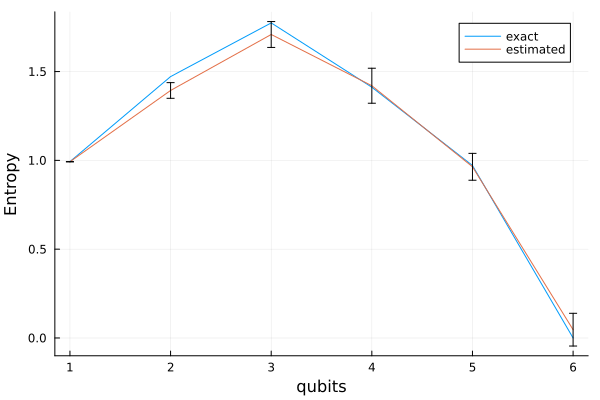

In [13]:
using Plots
plot(1:N,S,label="exact")
plot!(1:N,S_est,yerr = σ,label="estimated")

ylabel!("Entropy")
xlabel!("qubits")